## Goal  
Combine an **ARIMA** model for the mean and a **GARCH** model for the variance:

$$
\underbrace{r_t = \mu + \sum_{i=1}^{p}\varphi_i r_{t-i} + \sum_{j=1}^{q}\theta_j \varepsilon_{t-j}}_{\text{ARMA}(p,q)}
,\qquad
\varepsilon_t \sim \mathcal N(0,\sigma_t^2)
$$

$$
\sigma_t^2 = \omega + \sum_{i=1}^{P}\alpha_i \varepsilon_{t-i}^2 + \sum_{j=1}^{Q}\beta_j \sigma_{t-j}^2
$$

Steps  
1. Download S&P 500 prices and compute **log-returns**.  
2. Verify stationarity with the **ADF test** (decide the differencing order *d*).  
3. Search the best **ARIMA(p,0,q)** via AIC/BIC.  
4. Fit a **GARCH(P,Q)** on the ARIMA residuals.  
5. Produce rolling one-step forecasts: mean ± 2×volatility.  

## 1. Data download & preprocessing

In [3]:
import yfinance as yf
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

#  --- download S&P 500 adjusted close -------------------------------------
prices = (
    yf.download("^GSPC", start="2000-01-01", progress=False)["Close"]
      .dropna()
)

#  --- log returns, multiplied by 100 for readability ----------------------
rets = np.log(prices).diff().dropna() * 100

#  --- ADF stationarity test ----------------------------------------------
adf_stat, p_value, *_ = adfuller(rets)
print(f"ADF statistic = {adf_stat:.3f},  p-value = {p_value:.4f}")
# p-value < 0.05 ⇒ series is stationary ⇒ d = 0

C:\Users\13464\AppData\Local\Temp\ipykernel_38072\2087271278.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download("^GSPC", start="2000-01-01", progress=False)["Close"]


ADF statistic = -20.023,  p-value = 0.0000


## 2. Search the best ARIMA(p,0,q)

In [4]:
import itertools, warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

def best_arima(ts, p_max=5, q_max=5):
    best_aic, best_order = np.inf, None
    for p, q in itertools.product(range(p_max + 1), range(q_max + 1)):
        if (p, q) == (0, 0):
            continue
        try:
            model = ARIMA(ts, order=(p, 0, q)).fit()
            if model.aic < best_aic:
                best_aic, best_order = model.aic, (p, q)
        except:
            continue
    return best_order, best_aic

order, aic = best_arima(rets)
print(f"Selected ARIMA order (p,q) = {order},  AIC = {aic:.1f}")

arima_model = ARIMA(rets, order=(*order, 0)).fit()
arima_resid = arima_model.resid

Selected ARIMA order (p,q) = (5, 4),  AIC = 20811.1


## 3. Fit the GARCH(P,Q) on residuals

In [7]:
from arch import arch_model

def best_garch(eps, p_max=3, q_max=3):
    best_aic, best_order, best_model = np.inf, None, None
    for p, q in itertools.product(range(1, p_max + 1), range(1, q_max + 1)):
        try:
            mod = arch_model(eps, mean="Zero", vol="GARCH", p=p, q=q).fit(disp="off")
            if mod.aic < best_aic:
                best_aic, best_order, best_model = mod.aic, (p, q), mod
        except:
            continue
    return best_order, best_model

pq_order, garch_model = best_garch(arima_resid)
print(f"Selected GARCH order (P,Q) = {pq_order}")
garch_model.summary()

Selected GARCH order (P,Q) = (3, 3)


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14451.9
Distribution:                  Normal   AIC:                           28917.9
Method:            Maximum Likelihood   BIC:                           28965.3
                                        No. Observations:                 6431
Date:                Thu, Jul 31 2025   Df Residuals:                     6431
Time:                        03:45:45   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.3662      0.155      2.368  1.788e-02  [6.312e-02,  0.669]
alpha[1]       0.1097  1.770e-02      6.200  5.642e-10  [7.504e-02,  0.144]
alpha[2]       0.1657  5.875e-02      2.821  4.785e-03  [5.059e-02,  0.281]
alpha[3]       0.1261  9.843e-02      1.281      0.200 [-6.686e-02,  0.319]
beta[1]        0.0768      0.768      0.100      0.920    [ -1.428,  1.582]
beta[2]    6.5165e-16      0.537  1.212e-15      1.000    [ -1.053,  1.053]
beta[3]        0.4876      0.101      4.843  1.281e-06    [  0.290,  0.685]
===========================================================================

Covariance estimator: robust
"""

## 4. Rolling one-step forecast

In [12]:
N_FORE = 50                       
mu_forecast  = []
sigma_forecast = []

for i in range(N_FORE):
    train_series = rets.iloc[:-N_FORE + i]

    # 1) refit ARIMA on the expanding window
    mu_mod  = ARIMA(train_series, order=(*order, 0)).fit()
    mu_forecast.append(mu_mod.forecast().iloc[0])   # first position, not first label

    # 2) refit GARCH on ARIMA residuals
    eps     = mu_mod.resid
    g_mod   = arch_model(eps, mean="Zero", vol="GARCH",
                         p=pq_order[0], q=pq_order[1]).fit(disp="off")
    sigma_forecast.append(
        np.sqrt(g_mod.forecast(horizon=1).variance.values[-1, 0])
    )

mu_forecast  = pd.Series(mu_forecast,  index=rets.index[-N_FORE:])
sigma_forecast = pd.Series(sigma_forecast, index=rets.index[-N_FORE:])

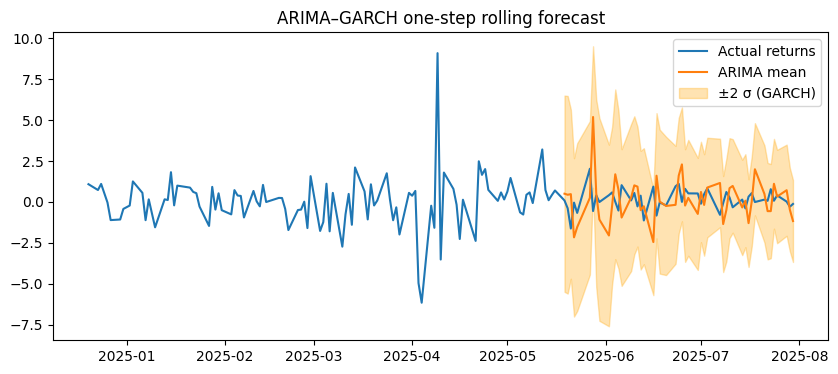

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(rets.index[-150:], rets[-150:], label="Actual returns")
plt.plot(mu_forecast.index, mu_forecast, label="ARIMA mean")
plt.fill_between(mu_forecast.index,
                 mu_forecast - 2 * sigma_forecast,
                 mu_forecast + 2 * sigma_forecast,
                 color="orange", alpha=0.3, label="±2 σ (GARCH)")
plt.title("ARIMA–GARCH one-step rolling forecast")
plt.legend()
plt.show()

* **ARIMA** captures the conditional mean; **GARCH** captures volatility clustering.  
* For most daily index returns, differencing is unnecessary (**d = 0**).  
* Rolling refits avoid look-ahead bias and adapt to regime changes.  
* The forecast band (±2 σ) is a ready-made Value-at-Risk envelope.  
* Extensions:  
  * Student-t innovations (`dist='t'`) for fat tails.  
  * EGARCH / GJR-GARCH for leverage effects.  
  * Multivariate GARCH for portfolios.  